# Recommender System
Module Data Mining - CPE Lyon 2024

*Auteurs : Hayotte Morgane et Ludwig Julie*

---


In [7]:
# Importation des bibliothèques
import os
import numpy as np
import math
import sys
import pandas as pd
import json
import requests # requêtes http
import urllib.request # téléchargement d'images
import shutil # recursive rem
from time import sleep
from PIL import Image
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.cluster import KMeans
from uuid import uuid4 #générateur d'identifiant unique
import random as rd
from SPARQLWrapper import SPARQLWrapper, JSON
from shutil import copyfile
from collections import Counter 

## **1.** Collecte de données

On récupère les images avec une requete via Wikidata, on les stocke dans le dossier image. 

Puis on crée un tableau dans un fichier json avec les metadonnées des images.

Le dossier images et le tableau json sont supprimés et récréés à chaque lancement. 

In [10]:
# Nombre d'images à télécharger maximum
NB_IMG_MAX = 100

#Fonction de récupération des données exif d'une image
def get_image_metadata(image_path_,index):
    try:
        with Image.open(image_path_) as img:
            width, height = img.size
            format = img.format
            exif_data = img._getexif()

            orientation = 'N/A'
            creation_date = 'N/A'
            camera_model = 'N/A'

            if exif_data:
                # Traitement des données EXIF...
                orientation = exif_data.get(0x0112, 'N/A')
                creation_date = exif_data.get(0x0132, 'N/A')
                camera_model = exif_data.get(0x0110, 'N/A')
            
            metadata = {
                'index': index,
                'filename': os.path.basename(image_path_),
                'size': os.path.getsize(image_path_),
                'format': format,
                'orientation': orientation,
                'width': width,
                'height': height,
                'creation_date': creation_date,
                'camera_model': camera_model
            }
            return metadata
        
    except FileNotFoundError:
        print(f"Error: Image file not found: {image_path_}")
        return {}

# Chemins
images_path = './images/'
json_path = "metadata_json.json"

if os.path.exists(images_path):
    shutil.rmtree(images_path)
os.makedirs(images_path)

if os.path.isfile(json_path):
    os.remove(json_path)

def get_results(endpoint_url, query):
    # Fonction pour exécuter la requête SPARQL
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# Endpoint SPARQL de Wikidata
endpoint_url = "https://query.wikidata.org/sparql"

# Requête SPARQL pour récupérer les images des chevaux depuis Wikidata
query= """
SELECT DISTINCT ?avion ?avionLabel ?image WHERE {
  ?avion wdt:P31 wd:Q197.
  ?avion wdt:P18 ?image.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],fr". }
}
LIMIT 100
"""

# Récupération des résultats de la requête SPARQL
results = get_results(endpoint_url, query)

images_metadata = []

img_dl = 0
for result in results["results"]["bindings"]:
    if img_dl >= NB_IMG_MAX:
        break
    url = result["image"]["value"]
    filename = os.path.basename(url)
    filepath = os.path.join(images_path, filename)
    
    # Téléchargement de l'image
    try:
        urllib.request.urlretrieve(url, filepath)
        # Mise à jour et affichage du nombre d'images téléchargées
        img_dl += 1
        print(f"Image {img_dl}/{NB_IMG_MAX} téléchargée.", end='\r')

        # Récupération et stockage des métadonnées de l'image
        image_metadata = get_image_metadata(filepath, img_dl)
        images_metadata.append(image_metadata)
        
    except Exception as e:
        print(f"Erreur lors du téléchargement de l'image {url}: {e}")

# Écriture des métadonnées dans un fichier JSON
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(images_metadata, f, ensure_ascii=False, indent=4)

print(f"{img_dl} images d'avions ont été téléchargées et leurs métadonnées sauvegardées dans {json_path}.")

100 images d'avions ont été téléchargées et leurs métadonnées sauvegardées dans metadata_json.json.


## **2.** Étiquetage et annotation

Nous ajoutons la couleur dominante de chaque image grâce à l'implémentation d'un algorithme de K-Means.

In [11]:
def recup_couleur_1(image_path):
    imgfile = Image.open(image_path)
    imgfile = imgfile.convert('RGB')  # Convertir en mode RVB pour éviter les problèmes de transparence
    imgfile = imgfile.resize((100, 100))  # Ajuster la taille de l'image
    numarray = np.array(imgfile)  # Obtenir les valeurs des pixels sous forme de tableau
    clusters = KMeans(n_clusters=4, n_init='auto')
    clusters.fit(numarray.reshape(-1, 3))  # Ajuster la forme de l'array à 2D
  
    # Trier les centres par fréquence décroissante
    counts = np.unique(clusters.labels_, return_counts=True)[1]
    sort_index = np.argsort(counts)[::-1]
    sorted_centers = clusters.cluster_centers_[sort_index]

    # Récupérer la couleur principale (premier centre trié)
    main_color = sorted_centers[0]
    return main_color.tolist()

# Chargement des métadonnées depuis le fichier JSON
json_path = "metadata_json.json"
with open(json_path, 'r', encoding='utf-8') as f:
    images_metadata = json.load(f)

# Appliquer la fonction pour chaque élément dans les métadonnées
for i, metadata in enumerate(images_metadata):
    print(f'\rProgression : {i+1}/{len(images_metadata)}', end='')
    path = os.path.join('images', metadata['filename'])
    
    if os.path.exists(path):
        main_color = recup_couleur_1(path)
        metadata['main_color'] = main_color
    else:
        print(f'\nFichier non trouvé : {path}')

# Sauvegarde des métadonnées mises à jour dans le fichier JSON
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(images_metadata, f, ensure_ascii=False, indent=4)

Progression : 100/100

## **3.** Analyses de données


Fonctions pour:
- Gestion de profils utilisateurs : enregistrés dans un fichier json (avec un uuid unique) 
- Stockage des images aimées ou pas aimées
- Calcul des recommandations

In [12]:

class Utilisateur():
    def __init__(self, name=None):
        self.id = str(uuid4())
        self.name = name
        self.path = {
            'profil': "./profils.json",
            'metadata': "./metadata_json.json"
        }
        self.likes = set()
        self.dislikes = set()
    
    def like(self, image):
        self.likes.add(str(image))
    
    def dislike(self, image):
        self.dislikes.add(str(image))
    
    def enregistrer(self):
        try:
            with open(self.path['profil'], 'r+', encoding='utf-8') as file:
                try:
                    profils = json.load(file)
                except json.JSONDecodeError:
                    profils = {}
        except FileNotFoundError:
            profils = {}
        
        profils[self.id] = {
            'name': self.name,
            'likes': list(self.likes),
            'dislikes': list(self.dislikes)
        }
        
        with open(self.path['profil'], 'w', encoding='utf-8') as file:
            json.dump(profils, file, ensure_ascii=False, indent=4)
    
    def charger(self, user_id):
        try:
            with open(self.path['profil'], 'r', encoding='utf-8') as file:
                profils = json.load(file)
                if user_id in profils:
                    self.id = user_id
                    self.name = profils[user_id]['name']
                    self.likes = set(profils[user_id]['likes'])
                    self.dislikes = set(profils[user_id]['dislikes'])
                    return True
                else:
                    return False
        except (FileNotFoundError, json.JSONDecodeError):
            return False
    
    def recommander(self):
        # Charger les métadonnées depuis le fichier JSON
        try:
            with open(self.path['metadata'], 'r', encoding='utf-8') as f:
                images_metadata = json.load(f)
        except FileNotFoundError:
            print("Fichier de métadonnées non trouvé.")
            return []
        except json.JSONDecodeError:
            print("Erreur de décodage du fichier JSON.")
            return []

        # Vérifier que les métadonnées contiennent les informations nécessaires
        if not all('main_color' in metadata for metadata in images_metadata):
            print("Les métadonnées doivent inclure les 'main_color' pour chaque image.")
            return []

        # Recommandation basée sur la couleur principale des images aimées
        id_images_aimees = list(self.likes)
        
        # Initialiser une liste pour stocker les distances
        distances = []

        # Calculer la distance de couleur entre chaque image non aimée et les images aimées
        for metadata in images_metadata:
            if str(metadata['index']) in id_images_aimees or str(metadata['index']) in self.dislikes:
                continue  # Ignorer les images déjà aimées ou non aimées
            main_color = np.array(metadata['main_color'])
            distance_cumulative = 0
            for liked_index in id_images_aimees:
                liked_metadata = next((item for item in images_metadata if str(item['index']) == liked_index), None)
                if liked_metadata:
                    liked_color = np.array(liked_metadata['main_color'])
                    distance = np.linalg.norm(main_color - liked_color)
                    distance_cumulative += distance
            # Calculer la distance moyenne si des images aimées existent
            if id_images_aimees:
                average_distance = distance_cumulative / len(id_images_aimees)
            else:
                average_distance = distance_cumulative
            distances.append((metadata['index'], average_distance))
        
        # Trier les images par distance moyenne croissante (les plus proches en premier)
        distances.sort(key=lambda x: x[1])
        
        # Retourner l'ID des premières images recommandées
        recommanded_indexes = [d[0] for d in distances[:5]]
        return recommanded_indexes


## **4.** Visualisation des données

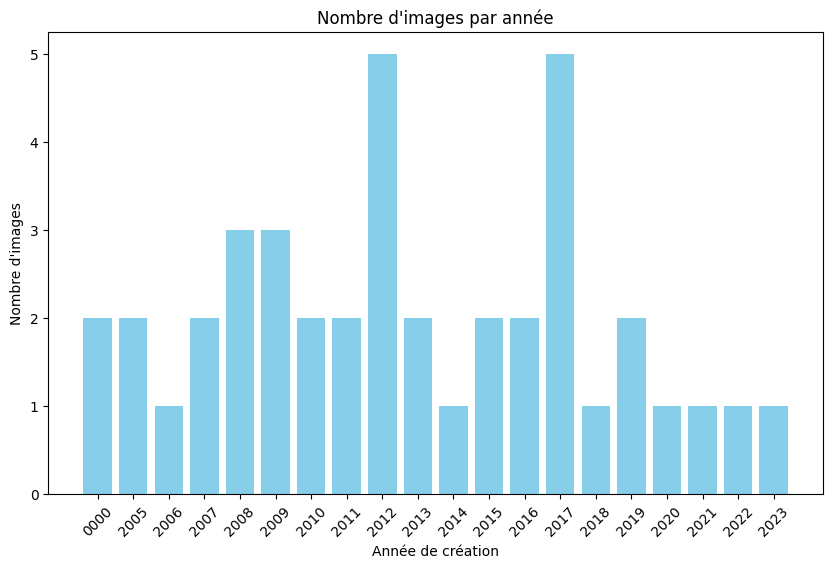

In [13]:
# Extraction des années à partir des métadonnées
years = [metadata['creation_date'][:4] for metadata in images_metadata if metadata.get('creation_date') != 'N/A']

# Comptage du nombre d'images par année
year_counts = Counter(years)

# Tri des années pour le graphique
sorted_years = sorted(year_counts.items())

# Séparation des données pour le tracé
years, counts = zip(*sorted_years)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(years, counts, color='skyblue')
plt.xlabel('Année de création')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par année')
plt.xticks(rotation=45)
plt.show()

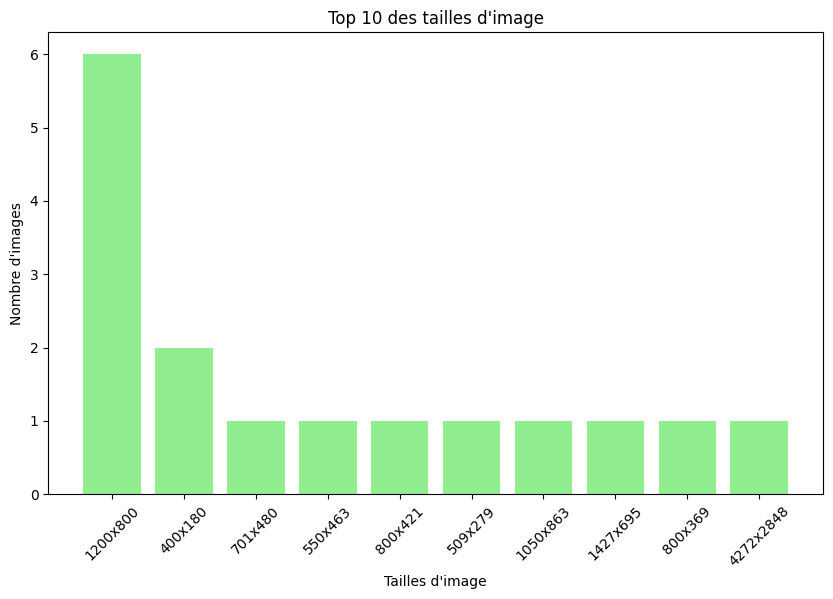

C:\Users\vpica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


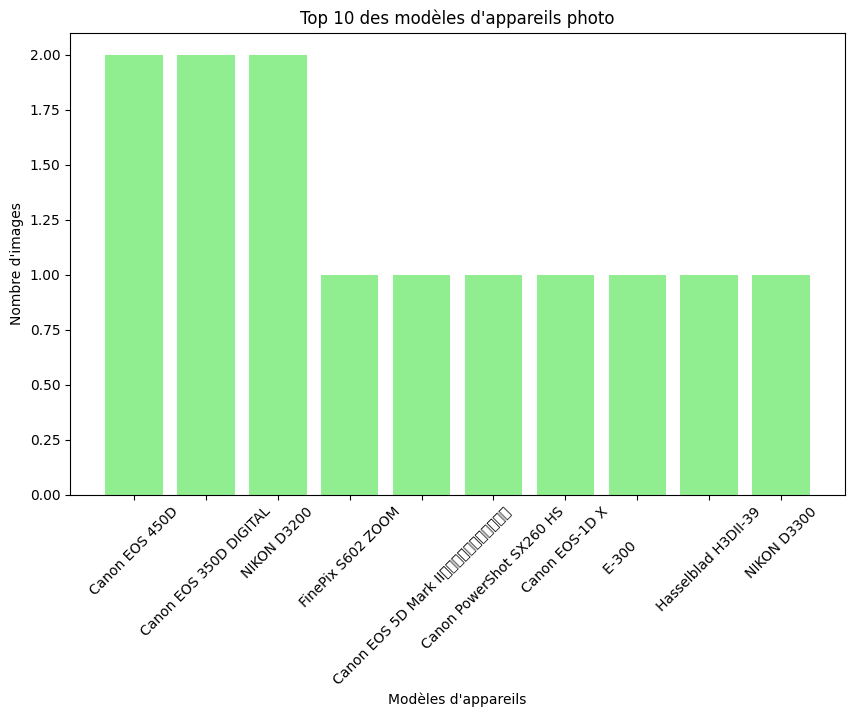

In [14]:
# Fonction ajustée pour limiter le nombre de catégories affichées
def plot_categorical_data_limited(data, title, xlabel, max_categories=10):
    counts = Counter(data)
    # Tri des catégories par fréquence et limitation au nombre spécifié
    most_common = counts.most_common(max_categories)
    categories, counts = zip(*most_common)
    
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='lightgreen')
    plt.xlabel(xlabel)
    plt.ylabel('Nombre d\'images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Application de la fonction ajustée pour chaque type de données

# Taille de l'image
image_sizes = [f"{metadata['width']}x{metadata['height']}" for metadata in images_metadata]
plot_categorical_data_limited(image_sizes, 'Top 10 des tailles d\'image', 'Tailles d\'image')

# Modèles d'appareils photo
camera_models = [metadata['camera_model'] for metadata in images_metadata if metadata.get('camera_model') != 'N/A']
plot_categorical_data_limited(camera_models, 'Top 10 des modèles d\'appareils photo', 'Modèles d\'appareils')

## **5.** Visualisation des données

Simulation utilisateur et affichage des photos recommandées

Êtes-vous déjà dans notre base de données ? (oui/non)
Entrez votre nom:
Entrez les index de vos photos préférées (séparés par des virgules):
Entrez les index de vos photos moins aimées (séparés par des virgules):
Merci coco! Votre profil a été enregistré avec l'ID 50b74be6-d127-4c9f-8629-7fc9f5da1c79. Voici vos photos recommandées:
[17, 22, 54, 60, 71]


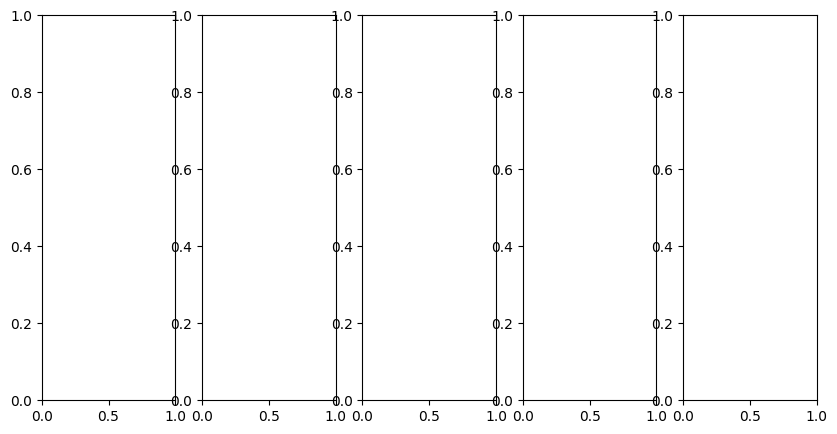

In [16]:
def main():
    print("Êtes-vous déjà dans notre base de données ? (oui/non)")
    response = input().lower()

    user = Utilisateur()

    if response == 'oui':
        print("Veuillez entrer votre ID:")
        user_id = input().strip()
        if user.charger(user_id):
            print(f"Bonjour, {user.name}! Voici vos photos recommandées:")
            recommandations = user.recommander()
            print(recommandations)
        else:
            print("Désolé, nous n'avons pas trouvé votre profil.")
    elif response == 'non':
        print("Entrez votre nom:")
        name = input().strip()
        print("Entrez les index de vos photos préférées (séparés par des virgules):")
        likes = input().strip().split(',')
        print("Entrez les index de vos photos moins aimées (séparés par des virgules):")
        dislikes = input().strip().split(',')
        
        user = Utilisateur(name=name)
        for like in likes:
            user.like(like)
        for dislike in dislikes:
            user.dislike(dislike)
        
        user.enregistrer()
        print(f"Merci {user.name}! Votre profil a été enregistré avec l'ID {user.id}. Voici vos photos recommandées:")
        recommandations = user.recommander()
        print(recommandations)

if __name__ == "__main__":
    main()